In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings('ignore')   
import seaborn as sns
import yfinance as yf
sns.set()

In [2]:
tickers=['^NSEBANK','^NSEI']
data = pd.DataFrame()
for ticker in tickers:
    data[ticker]=yf.download(ticker,start='2010-01-01',end='2025-7-7')['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3532 entries, 2010-01-04 to 2025-07-04
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ^NSEBANK  3532 non-null   float64
 1   ^NSEI     3530 non-null   float64
dtypes: float64(2)
memory usage: 82.8 KB


In [4]:
data.head()

,^NSEBANK,^NSEI
Date,,
2010-01-04,9112.244141,5232.200195
2010-01-05,9192.043945,5277.899902
2010-01-06,9222.892578,5281.799805
2010-01-07,9192.843750,5263.100098
2010-01-08,9160.593750,5244.750000


In [5]:
data.isna().sum()

^NSEBANK    0
^NSEI       2
dtype: int64

In [6]:
## Dropping Null Values
data.dropna(inplace=True)

In [7]:
data.head()

,^NSEBANK,^NSEI
Date,,
2010-01-04,9112.244141,5232.200195
2010-01-05,9192.043945,5277.899902
2010-01-06,9222.892578,5281.799805
2010-01-07,9192.843750,5263.100098
2010-01-08,9160.593750,5244.750000


In [8]:
data=data.asfreq('B')

In [9]:
data.head()

,^NSEBANK,^NSEI
Date,,
2010-01-04,9112.244141,5232.200195
2010-01-05,9192.043945,5277.899902
2010-01-06,9222.892578,5281.799805
2010-01-07,9192.843750,5263.100098
2010-01-08,9160.593750,5244.750000


In [10]:
data.isna().sum()

^NSEBANK    515
^NSEI       515
dtype: int64

In [11]:
data.fillna(method='ffill',inplace=True)

In [12]:
data.isna().sum()

^NSEBANK    0
^NSEI       0
dtype: int64

In [13]:
## Simplyfing the Datasets
data['Market_value']=data['^NSEBANK']

In [14]:
data.head()

,^NSEBANK,^NSEI,Market_value
Date,,,
2010-01-04,9112.244141,5232.200195,9112.244141
2010-01-05,9192.043945,5277.899902,9192.043945
2010-01-06,9222.892578,5281.799805,9222.892578
2010-01-07,9192.843750,5263.100098,9192.843750
2010-01-08,9160.593750,5244.750000,9160.593750


In [15]:
## Deleting Extra Columns 
del data['^NSEBANK'],data['^NSEI']

In [16]:
data.head()

,Market_value
Date,
2010-01-04,9112.244141
2010-01-05,9192.043945
2010-01-06,9222.892578
2010-01-07,9192.843750
2010-01-08,9160.593750


In [17]:
data.describe()

,Market_value
count,4045.000000
mean,25076.327577
std,13321.497160
min,7798.458984
25%,12424.555664
50%,22264.642578
75%,35123.988281
max,57459.449219


In [18]:
## Adding Returns to the dataframe
data['returns']=data.Market_value.pct_change(1)*100
data=data.iloc[1:]
data.head()

,Market_value,returns
Date,,
2010-01-05,9192.043945,0.875743
2010-01-06,9222.892578,0.335601
2010-01-07,9192.843750,-0.325807
2010-01-08,9160.593750,-0.350816
2010-01-11,9173.443359,0.140270


In [19]:
## Spliting the Date
size=int(len(data)*0.8)
train=data.iloc[:size]
test=data.iloc[size:]

In [20]:
# copying train data to df for simplefying
df=train.copy()

In [21]:
df.head()

,Market_value,returns
Date,,
2010-01-05,9192.043945,0.875743
2010-01-06,9222.892578,0.335601
2010-01-07,9192.843750,-0.325807
2010-01-08,9160.593750,-0.350816
2010-01-11,9173.443359,0.140270


In [22]:
train.tail()

,Market_value,returns
Date,,
2022-05-24,34289.750000,0.124235
2022-05-25,34339.101562,0.143925
2022-05-26,35094.492188,2.199797
2022-05-27,35612.886719,1.477139
2022-05-30,35826.531250,0.599908


In [23]:
test.head()

,Market_value,returns
Date,,
2022-05-31,35486.984375,-0.947753
2022-06-01,35620.386719,0.375919
2022-06-02,35613.234375,-0.020079
2022-06-03,35274.640625,-0.950753
2022-06-06,35309.789062,0.099642


## ploting ACF anf PACF plots

Text(0.5, 1.0, 'ACF Bank Nifty')

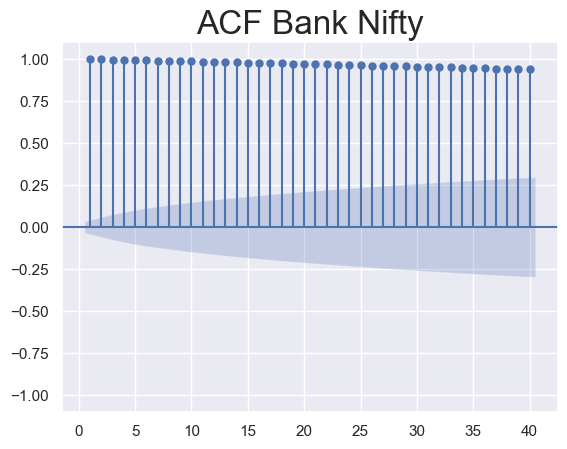

In [24]:
## ACF
sgt.plot_acf(df.Market_value,lags=40,zero=False)
plt.ylim(-1.1,1.1)
plt.title("ACF Bank Nifty",size=24)

Text(0.5, 1.0, 'PACF Bank Nifty')

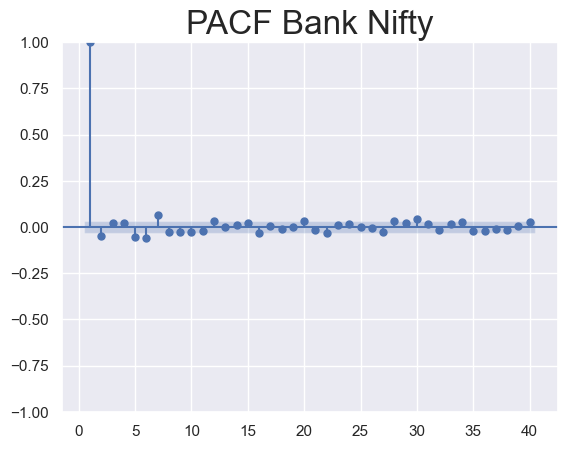

In [25]:
## Pacf 
sgt.plot_pacf(df.Market_value,lags=40,zero=False,method=('ols'))
plt.title("PACF Bank Nifty",size=24)

In [26]:
## Defining LLR Test for Easy Comparison
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Multiple MA models for many Lags and comparing them (for Prices)


In [27]:
model_ma1 = ARIMA(df.Market_value, order=(0,0,1))
result_ma1=model_ma1.fit()
result_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -31776.205
Date:                Sun, 14 Sep 2025   AIC                          63558.409
Time:                        13:41:31   BIC                          63576.655
Sample:                    01-05-2010   HQIC                         63564.947
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04    155.182    127.686      0.000    1.95e+04    2.01e+04
ma.L1          0.9752      0.004    248.632      0.000       0.967       0.983
sigma2      1.991e+07      0.018   1.12e+09      0.000    1.99e+07    1.99e+07
===================================================================================
Ljung-Box (L1) (Q):                2953.91   Jarque-Bera (JB):               248.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+23. Standard errors may be unstable.
"""

In [28]:
model_ma2 = ARIMA(df.Market_value, order=(0,0,2))
result_ma2=model_ma2.fit()
result_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -32561.942
Date:                Sun, 14 Sep 2025   AIC                          65131.883
Time:                        13:41:31   BIC                          65156.211
Sample:                    01-05-2010   HQIC                         65140.600
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04   1219.731     16.245      0.000    1.74e+04    2.22e+04
ma.L1          1.0361      0.002    578.762      0.000       1.033       1.040
ma.L2          0.9970      0.002    546.273      0.000       0.993       1.001
sigma2       7.56e+07      0.027   2.75e+09      0.000    7.56e+07    7.56e+07
===================================================================================
Ljung-Box (L1) (Q):                1144.23   Jarque-Bera (JB):               152.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.59e+25. Standard errors may be unstable.
"""

In [29]:
model_ma3 = ARIMA(df.Market_value, order=(0,0,3))
result_ma3=model_ma3.fit()
result_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 3)   Log Likelihood              -29572.430
Date:                Sun, 14 Sep 2025   AIC                          59154.859
Time:                        13:41:35   BIC                          59185.268
Sample:                    01-05-2010   HQIC                         59165.755
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04    259.458     76.369      0.000    1.93e+04    2.03e+04
ma.L1          2.2427      0.015    154.619      0.000       2.214       2.271
ma.L2          2.2207      0.033     67.453      0.000       2.156       2.285
ma.L3          0.9299      0.019     47.724      0.000       0.892       0.968
sigma2      5.067e+06      0.126   4.03e+07      0.000    5.07e+06    5.07e+06
===================================================================================
Ljung-Box (L1) (Q):                  16.13   Jarque-Bera (JB):               122.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.45e+22. Standard errors may be unstable.
"""

In [30]:
model_ma4 = ARIMA(df.Market_value, order=(0,0,4))
result_ma4=model_ma4.fit()
result_ma4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 4)   Log Likelihood              -30079.268
Date:                Sun, 14 Sep 2025   AIC                          60170.536
Time:                        13:41:39   BIC                          60207.027
Sample:                    01-05-2010   HQIC                         60183.611
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04    173.851    113.973      0.000    1.95e+04    2.02e+04
ma.L1          0.8337      0.005    156.249      0.000       0.823       0.844
ma.L2         -0.0521      0.002    -32.992      0.000      -0.055      -0.049
ma.L3          0.9025      0.002    552.126      0.000       0.899       0.906
ma.L4          0.9277      0.005    174.145      0.000       0.917       0.938
sigma2      7.147e+06      0.066   1.08e+08      0.000    7.15e+06    7.15e+06
===================================================================================
Ljung-Box (L1) (Q):                2273.73   Jarque-Bera (JB):               230.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+23. Standard errors may be unstable.
"""

In [31]:
model_ma5 = ARIMA(df.Market_value, order=(0,0,5))
result_ma5=model_ma5.fit()
result_ma5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 5)   Log Likelihood              -26791.388
Date:                Sun, 14 Sep 2025   AIC                          53596.776
Time:                        13:41:44   BIC                          53639.348
Sample:                    01-05-2010   HQIC                         53612.031
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04    219.548     90.251      0.000    1.94e+04    2.02e+04
ma.L1          2.2649      0.011    212.660      0.000       2.244       2.286
ma.L2          3.1163      0.023    136.914      0.000       3.072       3.161
ma.L3          2.8849      0.029    100.318      0.000       2.829       2.941
ma.L4          1.7908      0.023     79.584      0.000       1.747       1.835
ma.L5          0.6434      0.010     62.214      0.000       0.623       0.664
sigma2      9.106e+05   2.06e+04     44.161      0.000     8.7e+05    9.51e+05
===================================================================================
Ljung-Box (L1) (Q):                 467.50   Jarque-Bera (JB):               731.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_ma6 = ARIMA(df.Market_value, order=(0,0,6))
result_ma6=model_ma6.fit()
result_ma6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 6)   Log Likelihood              -32253.886
Date:                Sun, 14 Sep 2025   AIC                          64523.773
Time:                        13:41:46   BIC                          64572.427
Sample:                    01-05-2010   HQIC                         64541.207
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04   7420.720      2.670      0.008    5270.064    3.44e+04
ma.L1          1.6933      0.303      5.594      0.000       1.100       2.287
ma.L2          2.3421      0.455      5.145      0.000       1.450       3.234
ma.L3          2.6684      0.704      3.788      0.000       1.288       4.049
ma.L4          1.6651      0.703      2.369      0.018       0.288       3.042
ma.L5          1.0281      0.433      2.376      0.018       0.180       1.876
ma.L6          0.3926      0.291      1.349      0.177      -0.178       0.963
sigma2        6.9e+07      1.712   4.03e+07      0.000     6.9e+07     6.9e+07
===================================================================================
Ljung-Box (L1) (Q):                 115.98   Jarque-Bera (JB):               735.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.44e+22. Standard errors may be unstable.
"""

In [33]:
model_ma7 = ARIMA(df.Market_value, order=(0,0,7))
result_ma7=model_ma7.fit()
result_ma7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 7)   Log Likelihood              -32082.868
Date:                Sun, 14 Sep 2025   AIC                          64183.736
Time:                        13:41:53   BIC                          64238.472
Sample:                    01-05-2010   HQIC                         64203.349
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04   3004.837      6.594      0.000    1.39e+04    2.57e+04
ma.L1          1.4382      0.191      7.518      0.000       1.063       1.813
ma.L2          1.3387      0.351      3.819      0.000       0.652       2.026
ma.L3          1.8324      0.472      3.884      0.000       0.908       2.757
ma.L4          1.0206      0.594      1.717      0.086      -0.144       2.185
ma.L5          0.4119      0.467      0.882      0.378      -0.503       1.327
ma.L6          0.4806      0.340      1.413      0.158      -0.186       1.147
ma.L7          0.1521      0.179      0.850      0.395      -0.198       0.503
sigma2      5.575e+07      0.892   6.25e+07      0.000    5.58e+07    5.58e+07
===================================================================================
Ljung-Box (L1) (Q):                 719.61   Jarque-Bera (JB):               319.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.08   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+23. Standard errors may be unstable.
"""

In [34]:
model_ma8 = ARIMA(df.Market_value, order=(0,0,8))
result_ma8=model_ma8.fit()
result_ma8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Market_value   No. Observations:                 3235
Model:                 ARIMA(0, 0, 8)   Log Likelihood              -31647.498
Date:                Sun, 14 Sep 2025   AIC                          63314.996
Time:                        13:41:56   BIC                          63375.814
Sample:                    01-05-2010   HQIC                         63336.788
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e+04   1.43e+04      1.385      0.166   -8222.534    4.79e+04
ma.L1          1.7795      0.798      2.230      0.026       0.215       3.344
ma.L2          2.2242      1.442      1.543      0.123      -0.601       5.050
ma.L3          2.6568      1.868      1.422      0.155      -1.005       6.319
ma.L4          2.3454      2.328      1.008      0.314      -2.217       6.907
ma.L5          1.7676      2.591      0.682      0.495      -3.310       6.845
ma.L6          1.4678      2.359      0.622      0.534      -3.156       6.091
ma.L7          0.7084      1.750      0.405      0.686      -2.722       4.139
ma.L8          0.1753      0.794      0.221      0.825      -1.380       1.731
sigma2      4.901e+07   1.93e+06     25.416      0.000    4.52e+07    5.28e+07
===================================================================================
Ljung-Box (L1) (Q):                 142.49   Jarque-Bera (JB):               629.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.73   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.4e+14. Standard errors may be unstable.
"""

We stopped here only because p>z value is way more than our significance value so we will use ar6 or ar8 model I  didnt stopped on ar7 model because I wanted to see can next model will be better than the previous one and it is So now we will compare which is better MA6 or MA8

## Performing LLR Test on All three model

In [35]:
LLR_test(model_ma1,model_ma2)

np.float64(1.0)

In [36]:
LLR_test(model_ma2,model_ma3)

np.float64(0.0)

In [37]:
LLR_test(model_ma3,model_ma4)

np.float64(1.0)

In [38]:
LLR_test(model_ma4,model_ma5)

np.float64(0.0)

In [39]:
LLR_test(model_ma5,model_ma6)

np.float64(1.0)

In [40]:
LLR_test(model_ma6,model_ma7)

np.float64(0.0)

In [41]:
LLR_test(model_ma7,model_ma8)

np.float64(0.0)

In [42]:
## Comparing model 6 and 8
LLR_test(model_ma6,model_ma8,DF=2) # Here model 8 is better

np.float64(0.0)

In [43]:
## Comparing model 4 and 8
LLR_test(model_ma4,model_ma8,DF=4) # Here model 4 is better

np.float64(1.0)

In [44]:
## Comparing model 4 and 5
LLR_test(model_ma4,model_ma5) # Here model 4 is better

np.float64(0.0)

In [45]:
## Comparing model 1 and 4
LLR_test(model_ma1,model_ma4,DF=3) # Here model 5 is better

np.float64(0.0)

Here The best model we can find is model 4 so we will use this model

## Analysing the residuals

In [46]:
df['res_price']=result_ma4.resid

In [47]:
## Residual Mean
df.res_price.mean()

np.float64(-3.125263218890438)

In [48]:
## Residual Variance
df.res_price.var()

7014567.117884159

In [49]:
## Dicky Fuller Test
sts.adfuller(df.res_price)

(np.float64(-0.7740812599302398),
 np.float64(0.8266172089436479),
 11,
 3223,
 {'1%': np.float64(-3.4323805665026175),
  '5%': np.float64(-2.8624371819849372),
  '10%': np.float64(-2.5672475896829807)},
 np.float64(45878.814215215236))

Text(0.5, 1.0, 'ACF of Residuals FOR Price')

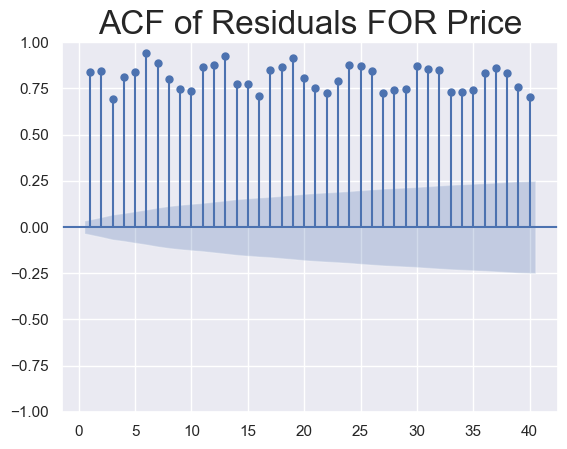

In [50]:
## Ploting ACF for Residuals
sgt.plot_acf(df.res_price,lags=40,zero=False)
plt.ylim(-1,1)
plt.title("ACF of Residuals FOR Price",size=24)

Text(0.5, 1.0, 'PACF of Residuals FOR Price')

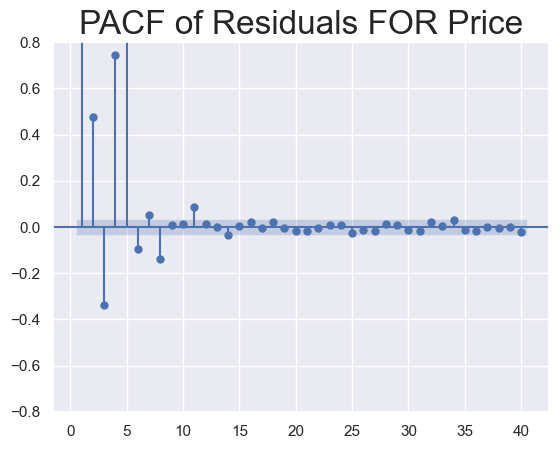

In [51]:
## Ploting PACF for Residuals
sgt.plot_pacf(df.res_price,lags=40,zero=False)
plt.ylim(-0.8,0.8)
plt.title("PACF of Residuals FOR Price",size=24)

## Now calculating The same Things for returns

In [52]:
## Running Dicky Fuller test for Returns
sts.adfuller(df.returns)

(np.float64(-16.59802883443395),
 np.float64(1.7746991329163392e-29),
 10,
 3224,
 {'1%': np.float64(-3.4323799361717584),
  '5%': np.float64(-2.862436903575556),
  '10%': np.float64(-2.5672474414633735)},
 np.float64(11842.696872288807))

## Ploting PACF and ACF for Returns

(-0.1, 0.1)

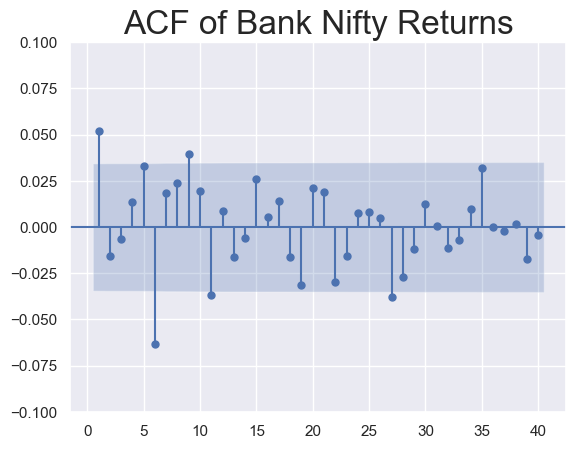

In [53]:
sgt.plot_acf(df.returns,lags=40,zero=False)
plt.title("ACF of Bank Nifty Returns",size=24)
plt.ylim(-0.1,0.1)

(-0.1, 0.1)

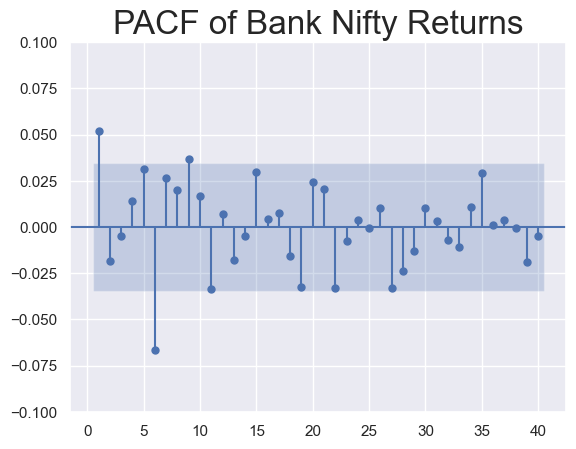

In [54]:
sgt.plot_pacf(df.returns,lags=40,zero=False)
plt.title("PACF of Bank Nifty Returns",size=24)
plt.ylim(-0.1,0.1)

## MA Models for Returns

In [55]:
model_ret_MA=ARIMA(df.returns, order=(0,0,1))
results_ret_MA = model_ret_MA.fit()
results_ret_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 3235
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5981.341
Date:                Sun, 14 Sep 2025   AIC                          11968.681
Time:                        13:43:10   BIC                          11986.927
Sample:                    01-05-2010   HQIC                         11975.219
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0542      0.029      1.897      0.058      -0.002       0.110
ma.L1          0.0537      0.013      4.064      0.000       0.028       0.080
sigma2         2.3632      0.019    122.006      0.000       2.325       2.401
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36778.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
model_ret_MA2=ARIMA(df.returns, order=(0,0,2))
results_ret_MA2 = model_ret_MA2.fit()
results_ret_MA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 3235
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -5980.975
Date:                Sun, 14 Sep 2025   AIC                          11969.950
Time:                        13:43:10   BIC                          11994.277
Sample:                    01-05-2010   HQIC                         11978.667
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0542      0.029      1.897      0.058      -0.002       0.110
ma.L1          0.0527      0.014      3.870      0.000       0.026       0.079
ma.L2         -0.0150      0.010     -1.461      0.144      -0.035       0.005
sigma2         2.3626      0.019    122.057      0.000       2.325       2.401
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36785.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
model_ret_MA3=ARIMA(df.returns, order=(0,0,3))
results_ret_MA3 = model_ret_MA3.fit()
results_ret_MA3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 3235
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -5980.899
Date:                Sun, 14 Sep 2025   AIC                          11971.797
Time:                        13:43:10   BIC                          12002.206
Sample:                    01-05-2010   HQIC                         11982.693
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0542      0.029      1.875      0.061      -0.002       0.111
ma.L1          0.0529      0.014      3.858      0.000       0.026       0.080
ma.L2         -0.0147      0.010     -1.432      0.152      -0.035       0.005
ma.L3         -0.0074      0.011     -0.659      0.510      -0.029       0.015
sigma2         2.3625      0.020    119.395      0.000       2.324       2.401
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36978.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We stopped here only because p>z value is way more than our significance value so we will use MA1 model I  didnt stopped on MA2 model because I wanted to see can next model will be better than the previous one

## Performing LLR Test on Returns Value

In [58]:
LLR_test(model_ret_MA,model_ret_MA2)

np.float64(0.392)

In [59]:
LLR_test(model_ret_MA2,model_ret_MA3)

np.float64(0.696)

As this both values are more than our significance value of 5% so we will use MA1 model

## Normalising the values

In [60]:
## Setting some benchmarks
benchmark=df.Market_value.iloc[0]
df['norm']=df.Market_value/benchmark*100

In [61]:
df.head()

,Market_value,returns,res_price,norm
Date,,,,
2010-01-05,9192.043945,0.875743,-10622.399758,100.000000
2010-01-06,9222.892578,0.335601,-5614.194581,100.335601
2010-01-07,9192.843750,-0.325807,-5849.225843,100.008701
2010-01-08,9160.593750,-0.350816,-2721.327494,99.657854
2010-01-11,9173.443359,0.140270,-3543.100830,99.797645


In [62]:
## Dickey Fuller Test for normalisation
sts.adfuller(df.norm)

(np.float64(-0.7300536711250394),
 np.float64(0.838810642684706),
 11,
 3223,
 {'1%': np.float64(-3.4323805665026175),
  '5%': np.float64(-2.8624371819849372),
  '10%': np.float64(-2.5672475896829807)},
 np.float64(16898.694281111868))

In [63]:
## Getting normalised Returns
Bench_ret=df.returns.iloc[0]
df['norm_ret']=df.returns/Bench_ret*100
sts.adfuller(df.norm_ret)

(np.float64(-16.59802883443397),
 np.float64(1.7746991329162888e-29),
 10,
 3224,
 {'1%': np.float64(-3.4323799361717584),
  '5%': np.float64(-2.862436903575556),
  '10%': np.float64(-2.5672474414633735)},
 np.float64(42212.33614805166))

In [64]:
df.head()

,Market_value,returns,res_price,norm,norm_ret
Date,,,,,
2010-01-05,9192.043945,0.875743,-10622.399758,100.000000,100.000000
2010-01-06,9222.892578,0.335601,-5614.194581,100.335601,38.321928
2010-01-07,9192.843750,-0.325807,-5849.225843,100.008701,-37.203509
2010-01-08,9160.593750,-0.350816,-2721.327494,99.657854,-40.059300
2010-01-11,9173.443359,0.140270,-3543.100830,99.797645,16.017319


## Normalised Returns

In [65]:
model_norm_ret_ma=ARIMA(df.norm_ret, order=(0,0,1))
results_norm_ret_ma = model_norm_ret_ma.fit()
results_norm_ret_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 3235
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -21308.297
Date:                Sun, 14 Sep 2025   AIC                          42622.594
Time:                        13:43:12   BIC                          42640.839
Sample:                    01-05-2010   HQIC                         42629.132
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1849      3.264      1.895      0.058      -0.213      12.583
ma.L1          0.0537      0.013      4.059      0.000       0.028       0.080
sigma2      3.085e+04    253.125    121.869      0.000    3.04e+04    3.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36778.34
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
model_norm_ret_ma2=ARIMA(df.norm_ret, order=(0,0,2))
results_norm_ret_ma2 = model_norm_ret_ma2.fit()
results_norm_ret_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 3235
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -21307.933
Date:                Sun, 14 Sep 2025   AIC                          42623.865
Time:                        13:43:12   BIC                          42648.193
Sample:                    01-05-2010   HQIC                         42632.582
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1849      3.267      1.893      0.058      -0.218      12.588
ma.L1          0.0527      0.014      3.863      0.000       0.026       0.079
ma.L2         -0.0150      0.010     -1.459      0.145      -0.035       0.005
sigma2      3.086e+04    253.298    121.839      0.000    3.04e+04    3.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36785.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
model_norm_ret_ma3=ARIMA(df.norm_ret, order=(0,0,3))
results_norm_ret_ma3 = model_norm_ret_ma3.fit()
results_norm_ret_ma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 3235
Model:                 ARIMA(0, 0, 3)   Log Likelihood              -21307.858
Date:                Sun, 14 Sep 2025   AIC                          42625.715
Time:                        13:43:12   BIC                          42656.124
Sample:                    01-05-2010   HQIC                         42636.611
                         - 05-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1849      3.305      1.871      0.061      -0.292      12.662
ma.L1          0.0529      0.014      3.850      0.000       0.026       0.080
ma.L2         -0.0147      0.010     -1.429      0.153      -0.035       0.005
ma.L3         -0.0074      0.011     -0.658      0.511      -0.029       0.015
sigma2      3.087e+04    259.107    119.142      0.000    3.04e+04    3.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             36978.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Same Reasons as for Returns

## Analysing The Residuals

In [68]:
## Adding the column of residual returns 
df['res_ret']=results_ret_MA.resid

In [69]:
## Calculating mean of residual returns 
df.res_ret.mean()

np.float64(-2.5861116279450372e-06)

In [70]:
## Calculating mean of residual variance
df.res_ret.var()

2.363925796039996

In [71]:
## Dicky Fuller Test of Residual Returns
sts.adfuller(df.res_ret)

(np.float64(-16.64576979816198),
 np.float64(1.6200072417115553e-29),
 10,
 3224,
 {'1%': np.float64(-3.4323799361717584),
  '5%': np.float64(-2.862436903575556),
  '10%': np.float64(-2.5672474414633735)},
 np.float64(11842.604583609864))

Text(0.5, 1.0, 'ACF of Residuals FOR Returns')

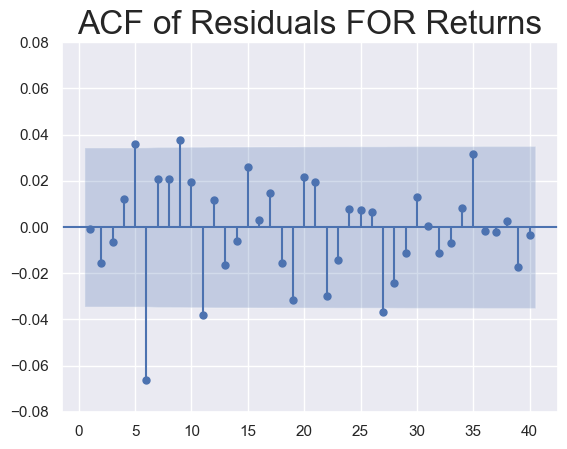

In [72]:
## Ploting ACF of Residual Returns
sgt.plot_acf(df.res_ret,lags=40,zero=False)
plt.ylim(-0.08,0.08)
plt.title("ACF of Residuals FOR Returns",size=24)

Text(0.5, 1.0, 'Residual of Returns')

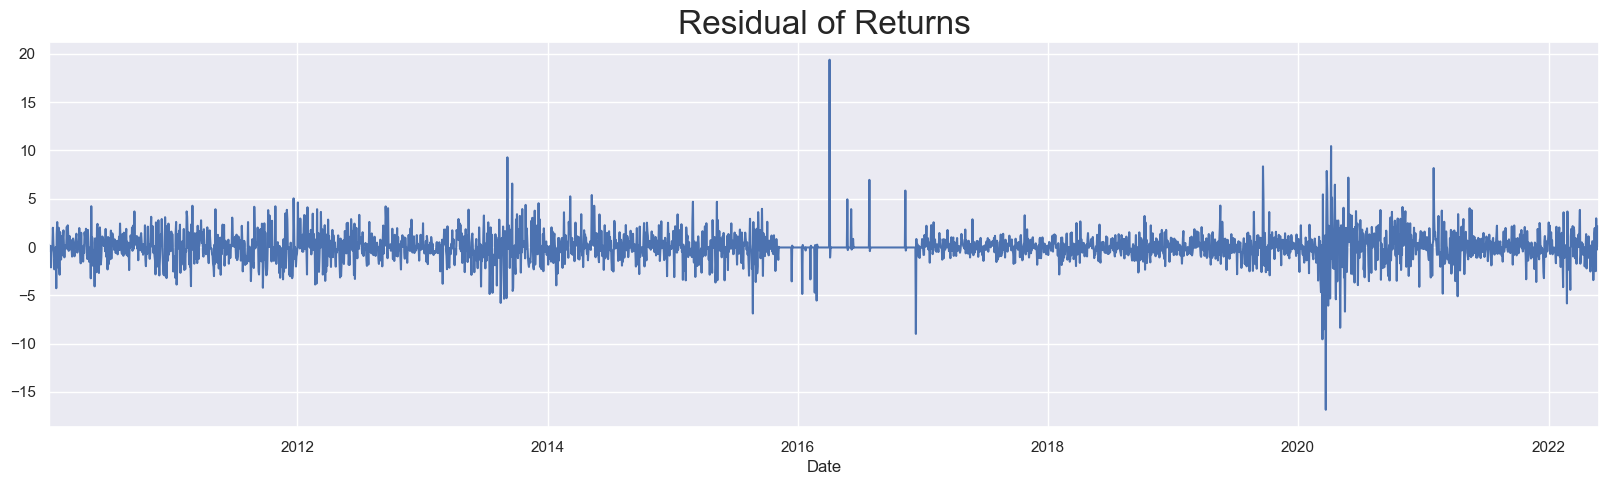

In [73]:
## Ploting Residual Returns
df.res_ret[1:].plot(figsize=(20,5))
plt.title("Residual of Returns",size=24)

## forcasting Furture values with our predicted ones

In [74]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date='2022-06-01'
end_date='2025-01-1'

In [75]:
df_pred=result_ma4.predict(start=start_date,end=end_date)

Text(0.5, 1.0, 'predictions VS actual')

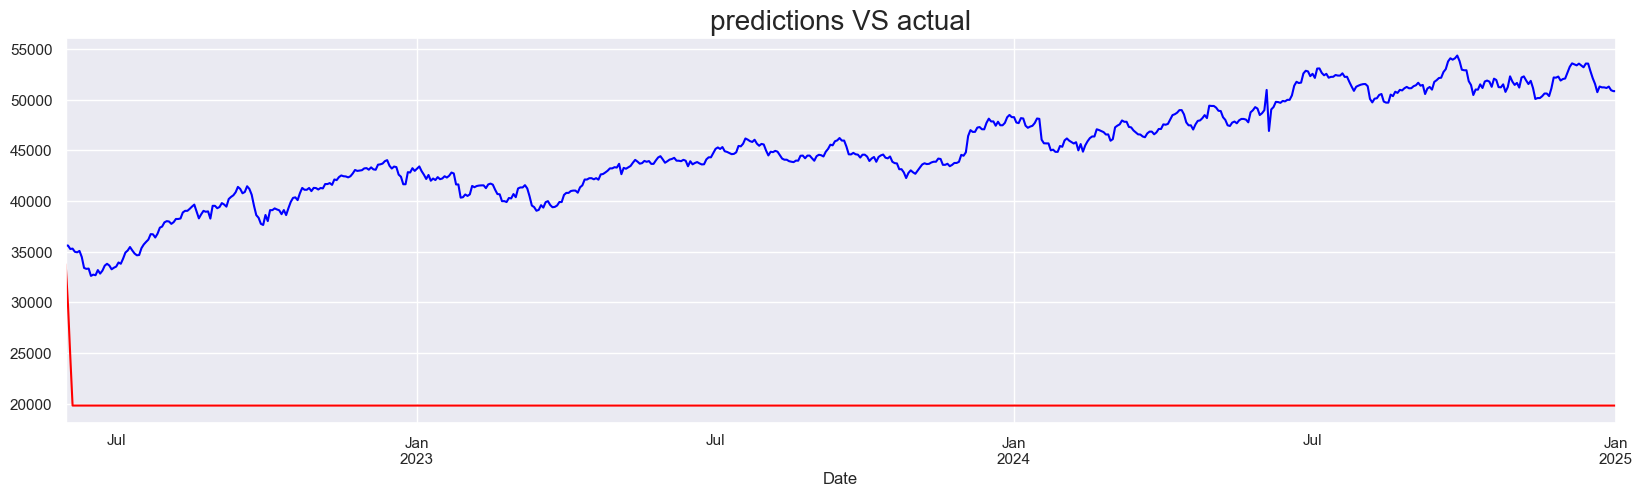

In [76]:
df_pred[start_date:end_date].plot(figsize=(20,5),color='red')
test.Market_value[start_date:end_date].plot(figsize=(20,5),color='blue')
plt.title("predictions VS actual",size=20)

In [77]:
df_pred_returns=results_ret_MA.predict(start=start_date,end=end_date)

Text(0.5, 1.0, 'predictions VS actual')

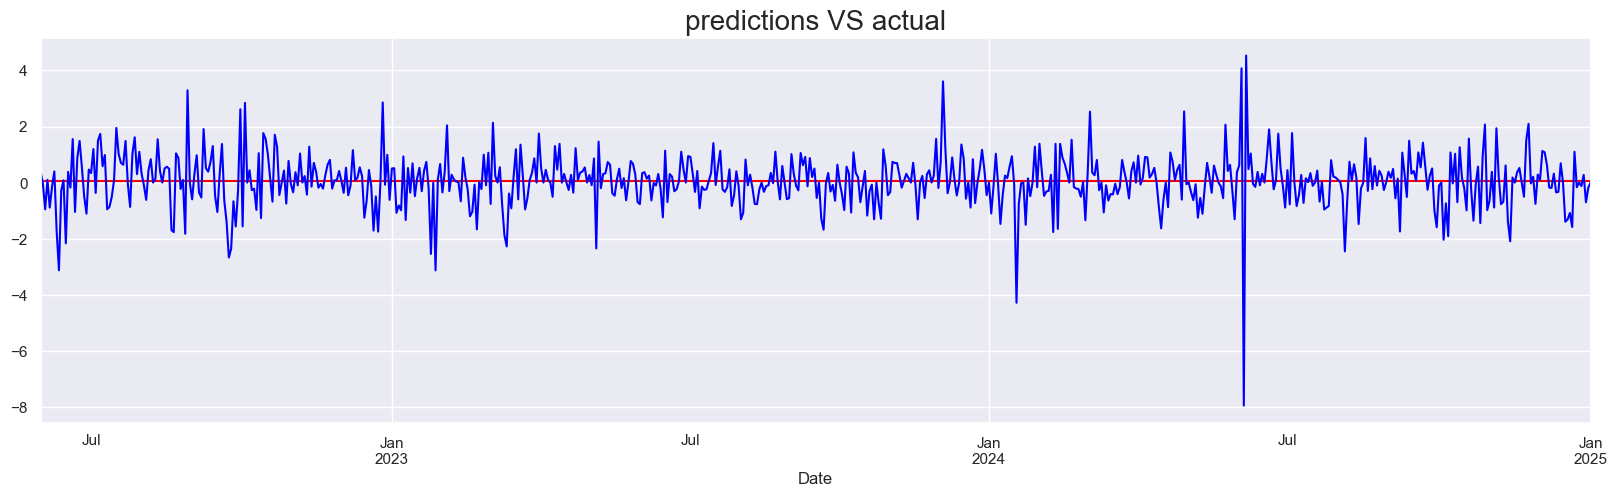

In [78]:
df_pred_returns[start_date:end_date].plot(figsize=(20,5),color='red')
test.returns[start_date:end_date].plot(figsize=(20,5),color='blue')
plt.title("predictions VS actual",size=20)

## a quick note that I will not use Any exogenous varianbles to brigten things up as they drastically improve model predictions
